In [5]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "sgpjesus/bank-account-fraud-dataset-neurips-2022",
    path='Base.csv'
)
# print(df.head())


100%|██████████| 82.4M/82.4M [00:05<00:00, 15.7MB/s]

Extracting zip of Base.csv...


In [ ]:
print(df.columns)
print(df.fraud_bool.unique())


Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')
[0 1]


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# numeric_df = df.select_dtypes(include='number')
# print(numeric_df.shape)
# corr = numeric_df.corr()
# # plt.figure(figsize=(10, 8))
# sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
# plt.title("Correlation Heatmap")
# plt.show()

print(df.shape)
print(df.info())
print(df.isnull().sum())

(1000000, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h            

In [ ]:
print(df['fraud_bool'].value_counts())
df['fraud_bool'].value_counts(normalize=True)

fraud_bool
0    988971
1     11029
Name: count, dtype: int64


,proportion
fraud_bool,
0,0.988971
1,0.011029


Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'email_is_free', 'phone_home_valid',
       'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes',
       'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count',
       'month'],
      dtype='object')


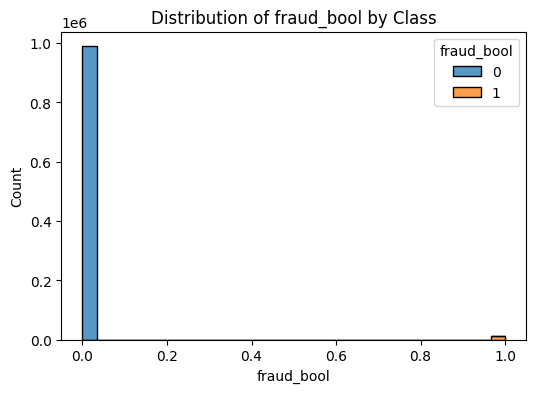

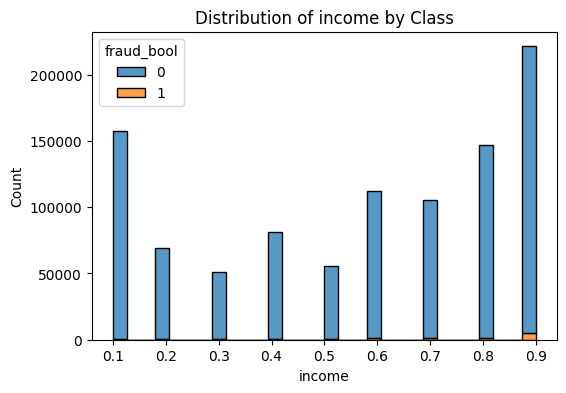

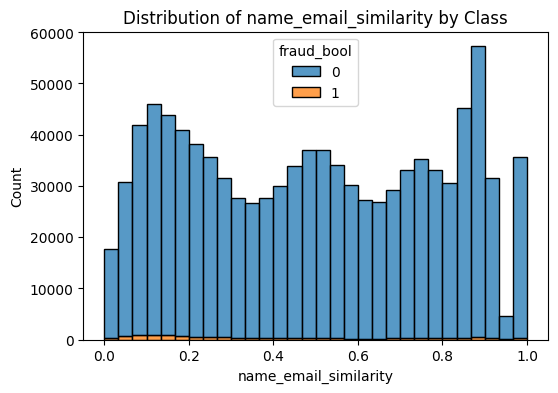

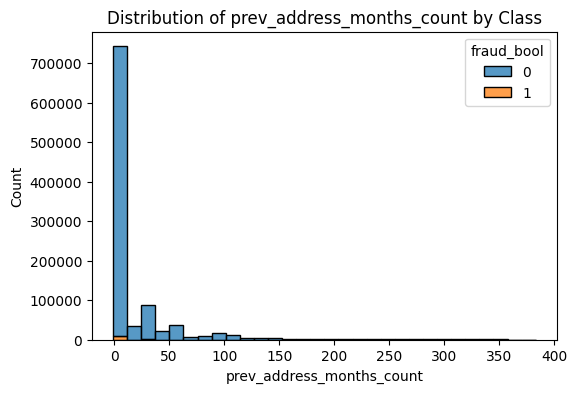

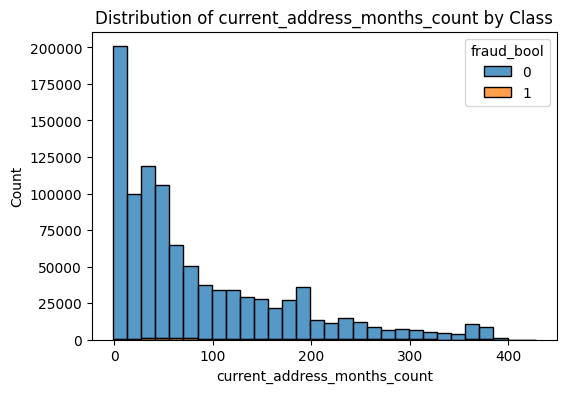

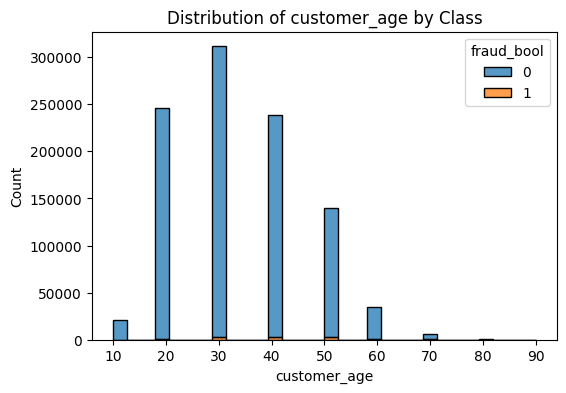

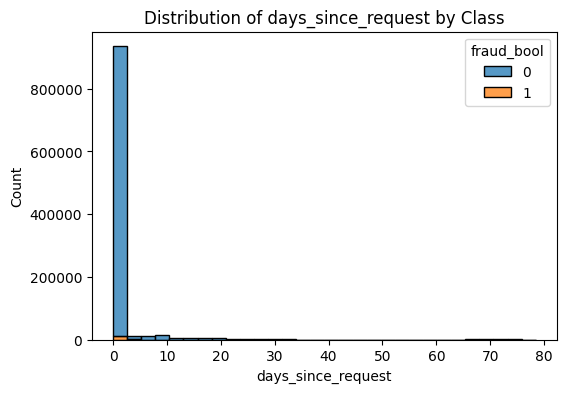

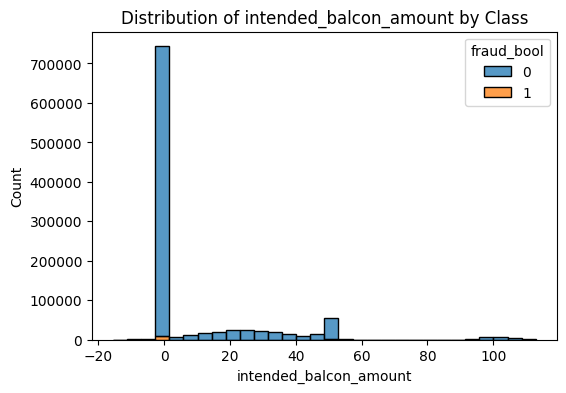

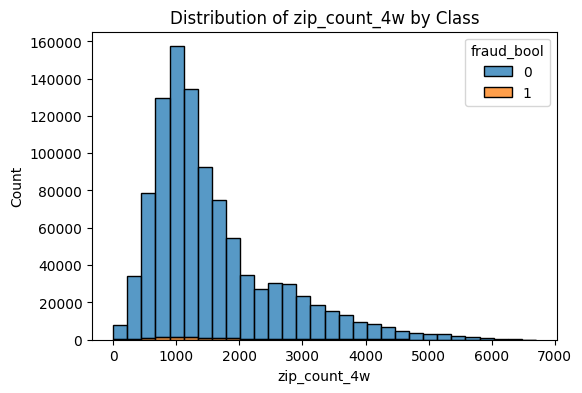

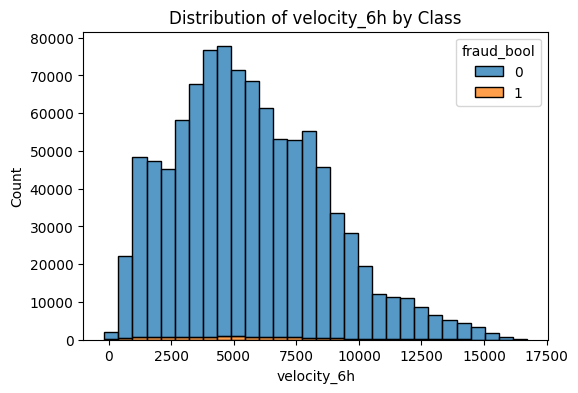

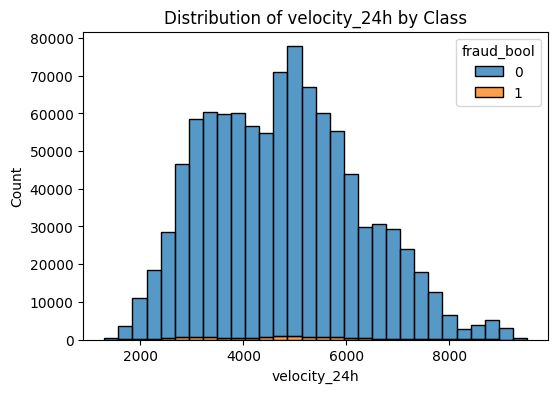

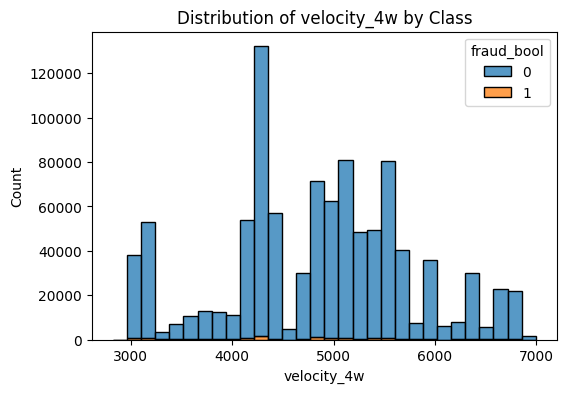

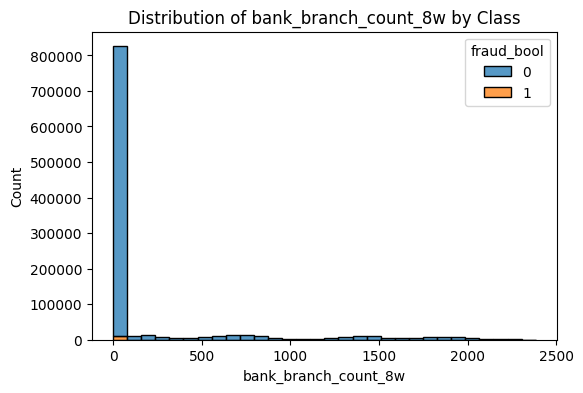

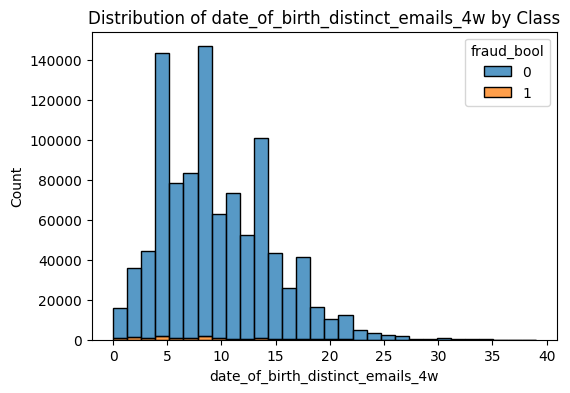

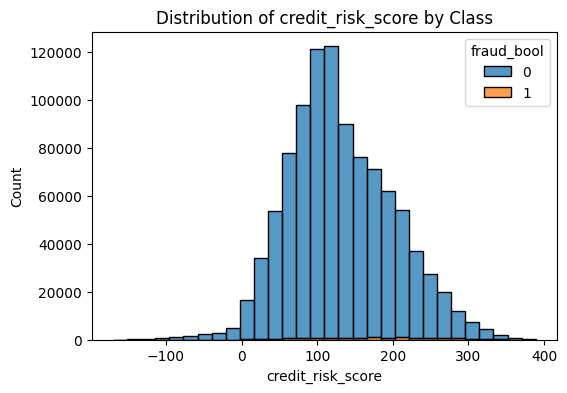

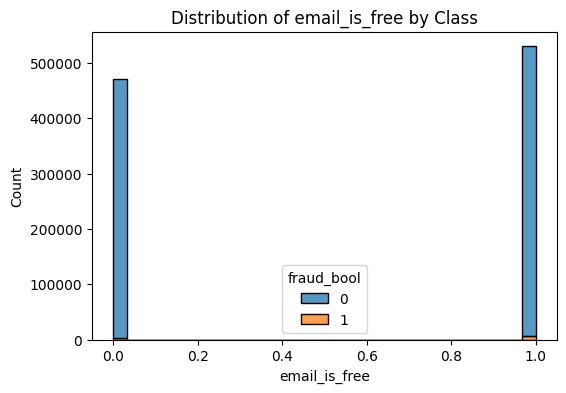

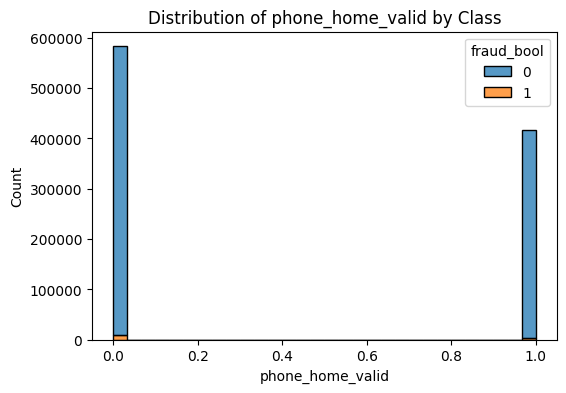

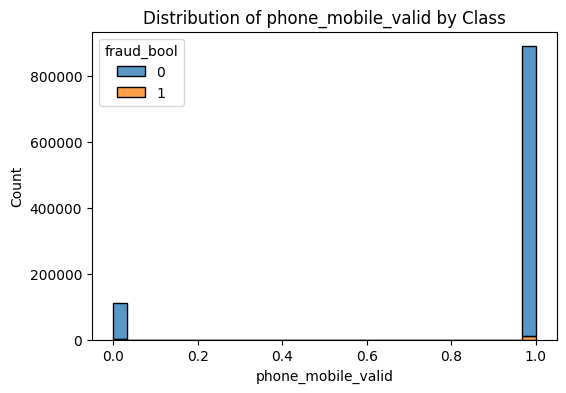

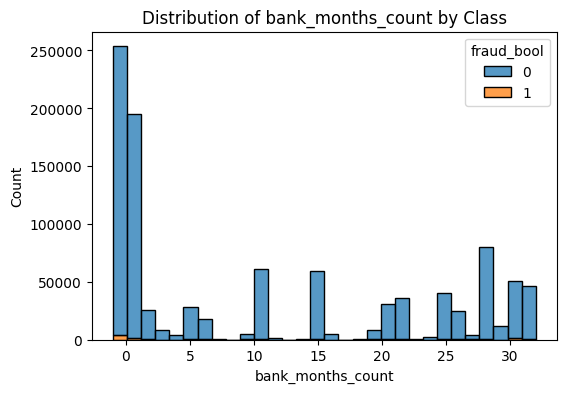

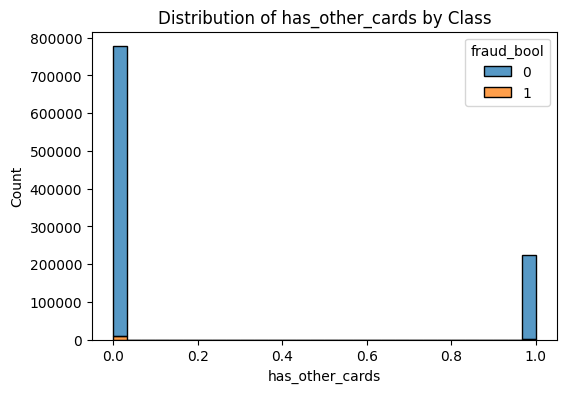

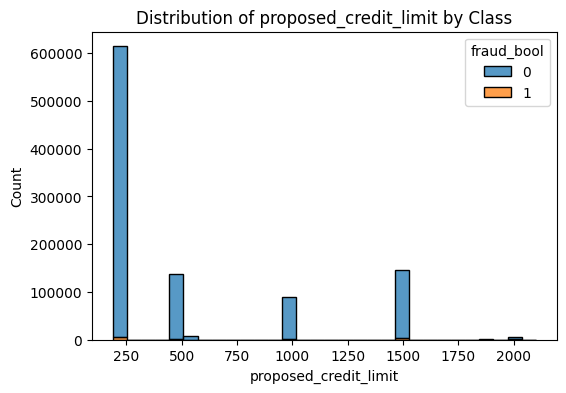

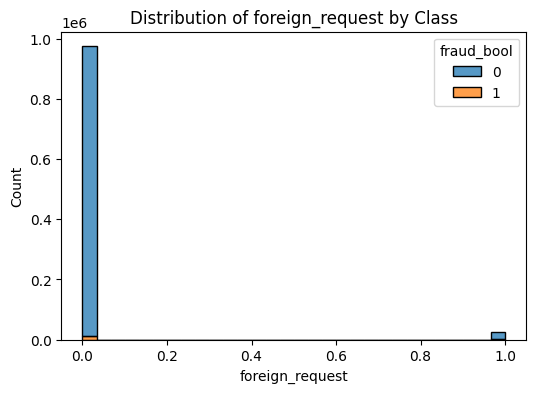

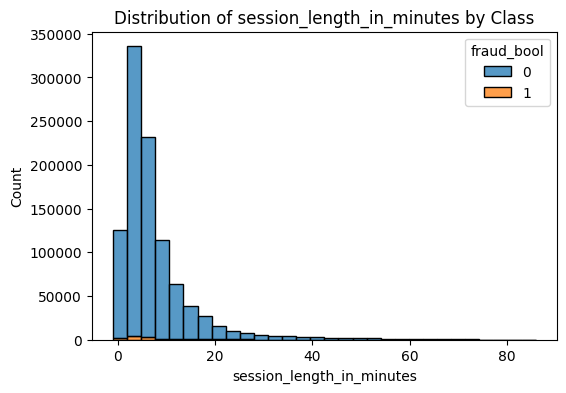

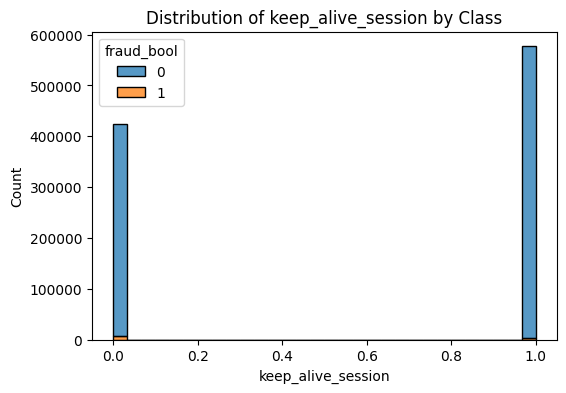

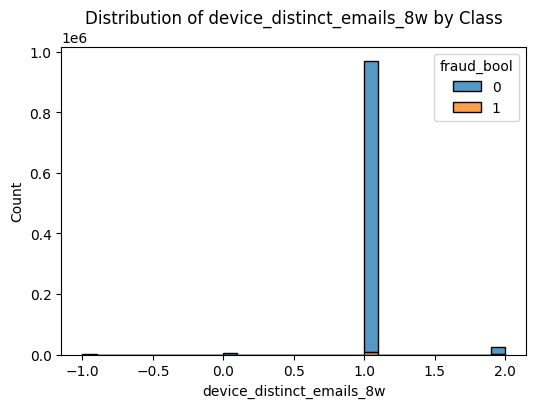

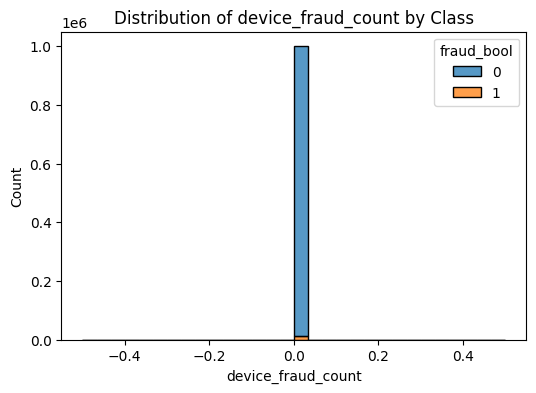

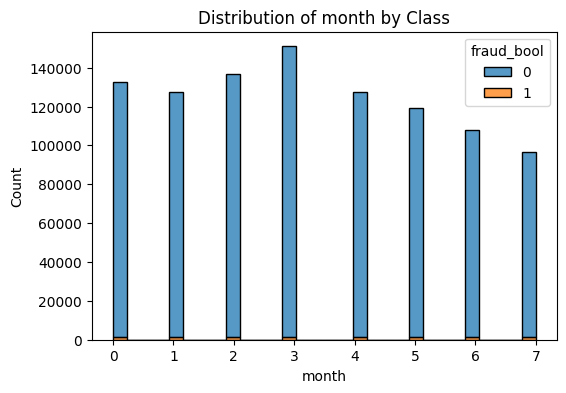

In [ ]:
numeric_cols = df.select_dtypes(include='number').columns
print(numeric_cols)
import seaborn as sns

import matplotlib.pyplot as plt

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, hue='fraud_bool', bins=30, kde=False, multiple='stack')
    plt.title(f'Distribution of {col} by Class')
    plt.show()

**So by looking at the dataset/distribution of a few features, we see that we clearly have a class imbalance issue. This is also expected given that there aren't any fraud cases which occur that frequently.**

In order to tackle this issue, we need to have 2 options:
1) Either reduce the majority class close to the number of instances of the minority one
          OR
2) Increase the minority class instances close to the majority ones to have a balanced dataset so that our model isn't biased to any one class and we have a clear/genralized model.

**Ways/Algorithm/Approach We Have in mind:**
1) GAN for Synthetic Minority (Fraud) Data: Torch/Vanilla/DCGAN/CTGAN
    References:
        1.   CT GAN: https://www.cai.sk/ojs/index.php/cai/article/view/2024_1_213
        2.   SMOTE: https://www.mdpi.com/2227-7072/11/3/110


2) Cost-Sensitive Learning: RandomForest/Cost Sensitive Loss Function.
    References:
        1. Cummulative Cost Boosting:https://dl.acm.org/doi/abs/10.1007/s10115-022-01780-8
        2. GAN & Cost: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3255-x
        
3) SMOTE: Already in place. So keep it for last.

# **# Approach 1: TORCH GANs**

In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchgan.trainer import Trainer
from torchgan.models import Generator, Discriminator
from torchgan.losses import GeneratorLoss, DiscriminatorLoss

In [37]:
# Checking if all are numeric dtypes or not as the torch needs it to be numeric.
# print(df.dtypes)
from pandas.api.types import is_numeric_dtype
is_not_numeric = ~df.dtypes.apply(is_numeric_dtype)
non_numeric_columns = df.dtypes[is_not_numeric].index.tolist()
print(non_numeric_columns)
# Below are the columns we need to convert to numeric in order to not lose any import feature.
#['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
# print(df['payment_type'].unique())

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


# Converting non-numeric columns to numeric

In [40]:
print(df["payment_type"].unique())
print(df["employment_status"].unique())
print(df["housing_status"].unique())
print(df["source"].unique())
print(df["device_os"].unique())

['AA' 'AD' 'AB' 'AC' 'AE']
['CB' 'CA' 'CC' 'CF' 'CD' 'CE' 'CG']
['BC' 'BE' 'BD' 'BA' 'BB' 'BF' 'BG']
['INTERNET' 'TELEAPP']
['linux' 'other' 'windows' 'x11' 'macintosh']


# Encoding or Feature Selection first?
An important thing to look at here is the order .i.e. what to do first?
Feature selection then encoding or encoding first and then feature selection?

Upon investigation and the nature of the approach, it seems like encoding the categorical columns first and then doing feature selection would be the right way to go ahead.
Reason:
We agree that by doing so we might increase the number of features uncessarily but in order to not drop any potential important feature we decided to do encoding first.

In [46]:
# Encoding (One Hot):
df_encoded = pd.get_dummies(df, columns=non_numeric_columns, drop_first=False)
print("Original shape:", df.shape)
print("Encoded shape:", df_encoded.shape)
print(df_encoded.columns)
print(df_encoded["device_os_x11"].unique())

Original shape: (1000000, 32)
Encoded shape: (1000000, 53)
Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'email_is_free', 'phone_home_valid',
       'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes',
       'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count',
       'month', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC',
       'payment_type_AD', 'payment_type_AE', 'employment_status_CA',
       'employment_status_CB', 'employment_status_CC', 'employment_status_CD',
       'employment_status_CE', 'employment_status_CF', 'employment_status_CG',
       'housing_

# Feature Selection
**Now we do Feature selection to see which are the most relevant in order to reduce uncessary complexity of the model. **

# UniVariate Analysis:
1) Helpful to see which features individually correalte with the target column (fraud_bool)

In [77]:

X = df_encoded.drop(columns=['fraud_bool'])
y = df_encoded['fraud_bool']

import seaborn as sns
import matplotlib.pyplot as plt

# Finding the relation with the target column (fraud_bool).
# correlations = X.corrwith(y).sort_values(ascending=False)
# print(correlations)


# By executing we got the below error indicating that we are dividing something by 0. Happens because of the following:
# corr(X,Y) = COV(X, Y)/(stdx * stdy)

# Means one or both of the std deviations are having the value 0 somewhere.

# /usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
#   c /= stddev[:, None]
# /usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
#   c /= stddev[None, :]


zero_var_cols = X.columns[X.std() == 0].tolist()
print("Columns with zero variance:", zero_var_cols)


if len(zero_var_cols) > 0:
    X = X.drop(columns=zero_var_cols)
    print(f"Dropped {len(zero_var_cols)} zero-variance columns.")
else:
    print("No zero-variance columns found.")


correlations = X.corrwith(y).sort_values(ascending=False)
print(correlations)


Columns with zero variance: ['device_fraud_count']
Dropped 1 zero-variance columns.
housing_status_BA                   0.114428
device_os_windows                   0.078263
credit_risk_score                   0.070624
proposed_credit_limit               0.068907
customer_age                        0.062959
income                              0.045079
device_distinct_emails_8w           0.035704
current_address_months_count        0.033701
payment_type_AC                     0.031510
email_is_free                       0.027758
employment_status_CC                0.025899
employment_status_CA                0.018231
foreign_request                     0.016885
month                               0.013250
session_length_in_minutes           0.008999
device_os_macintosh                 0.006719
zip_count_4w                        0.005212
source_TELEAPP                      0.003922
payment_type_AB                     0.001629
employment_status_CG                0.000902
days_since_reque

The range i.e. the min/max of the correlations are as: MIN:-0.05029641281959549 | MAX:0.1144281771644327


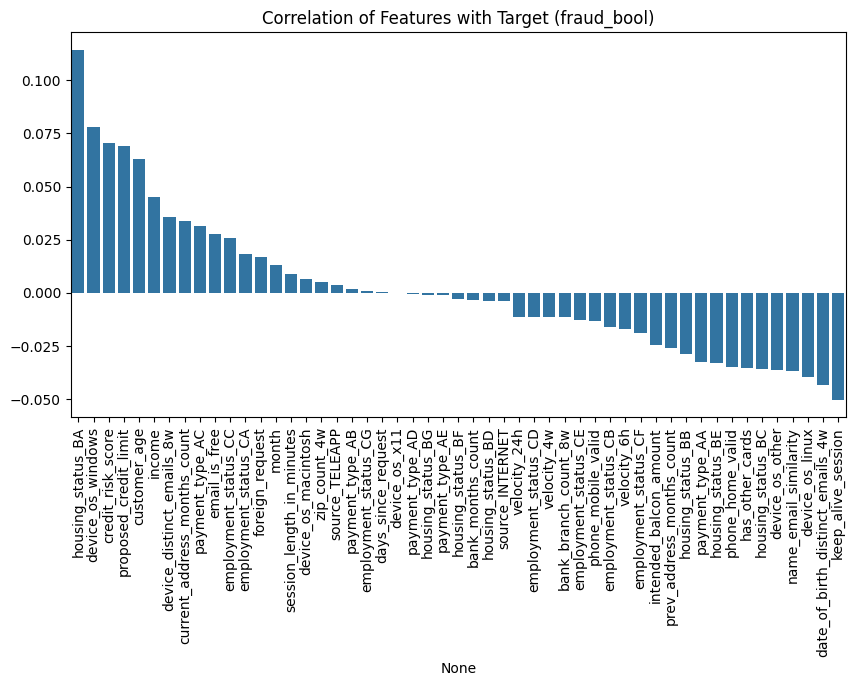

In [81]:
# Plotting those Correaltions
print(f"The range i.e. the min/max of the correlations are as: MIN:{min(correlations)} | MAX:{max(correlations)}")
plt.figure(figsize=(10,5))
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=90)
plt.title("Correlation of Features with Target (fraud_bool)")
plt.show()

# Bivariate/Multi-Variate Analysis
  1) Useful for determining redundant features. This compares feature with      feature. If one is highly correlated with the other, you can drop one.

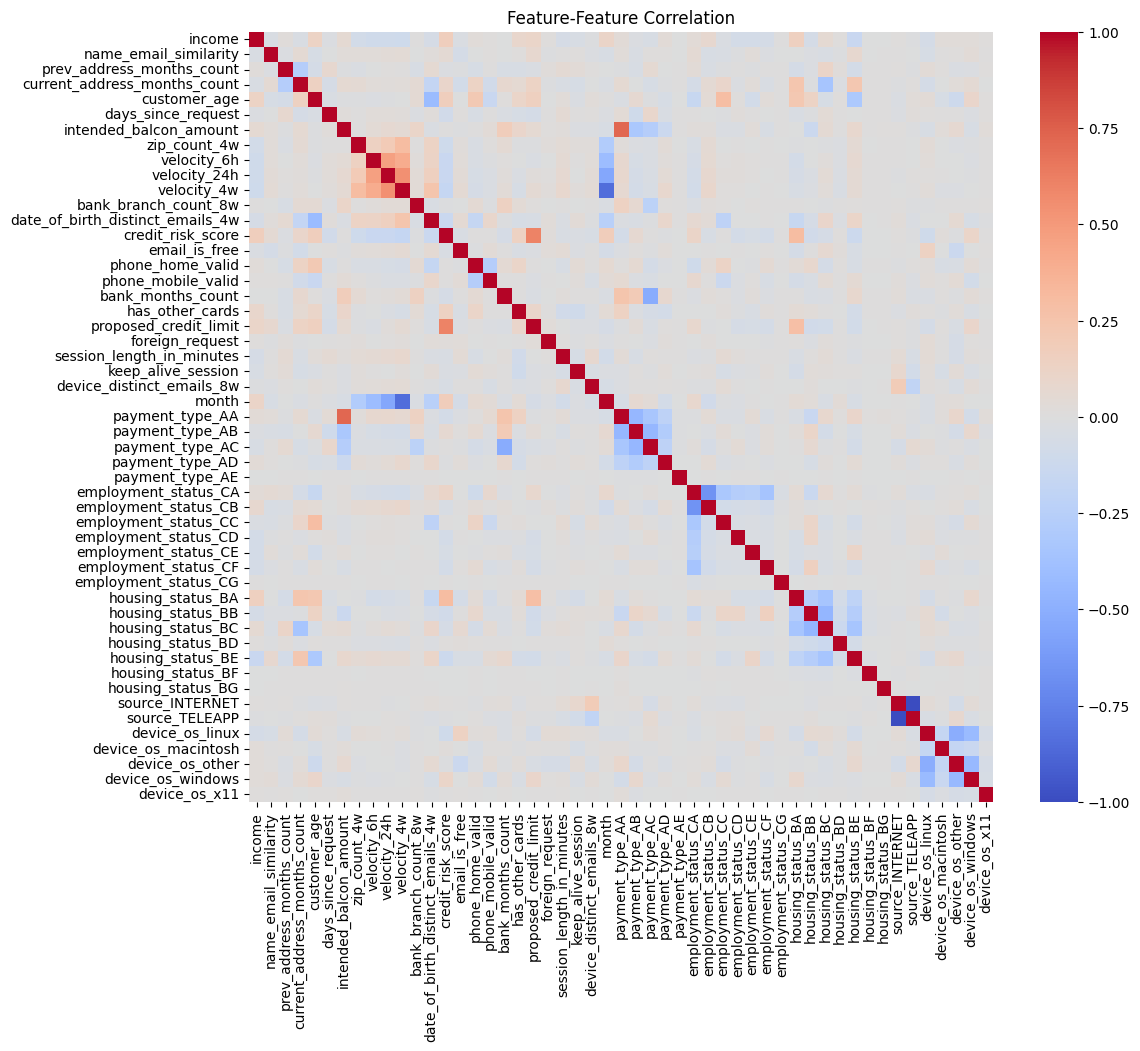

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of feature-feature correlations
plt.figure(figsize=(12,10))
sns.heatmap(X.corr(), cmap='coolwarm', center=0)
plt.title("Feature-Feature Correlation")
plt.show()

# Example: numeric vs target
# for col in X.columns:
#     sns.boxplot(x=y, y=X[col])
#     plt.title(f"{col} vs fraud_bool")
#     plt.show()


In [84]:
# Before executing this make sure you keep the relevant columns in the df_encoded variable itself.
fraud_df = df_encoded[df_encoded['fraud_bool'] == 1]
print(fraud_df.shape)
# fraud_numeric = fraud_df.select_dtypes(include=['int64', 'float64', 'bool']).copy()
fraud_df = fraud_df.astype('float32')
print(fraud_df.dtypes)

(11029, 53)
fraud_bool                          float32
income                              float32
name_email_similarity               float32
prev_address_months_count           float32
current_address_months_count        float32
customer_age                        float32
days_since_request                  float32
intended_balcon_amount              float32
zip_count_4w                        float32
velocity_6h                         float32
velocity_24h                        float32
velocity_4w                         float32
bank_branch_count_8w                float32
date_of_birth_distinct_emails_4w    float32
credit_risk_score                   float32
email_is_free                       float32
phone_home_valid                    float32
phone_mobile_valid                  float32
bank_months_count                   float32
has_other_cards                     float32
proposed_credit_limit               float32
foreign_request                     float32
session_length_in_mi

In [56]:
# Converting to Tensor for GANs
print(fraud_df.shape)
fraud_tensor = torch.tensor(fraud_df.values, dtype=torch.float32)
print(type(fraud_tensor))
print(fraud_tensor)

fraud_dataset = TensorDataset(fraud_tensor)
print(type(fraud_dataset))
print(fraud_dataset)

fraud_loader = DataLoader(fraud_dataset, batch_size=64, shuffle=True)
print(type(fraud_loader))
print(fraud_loader)

print(len(fraud_dataset))

(11029, 53)
<class 'torch.Tensor'>
tensor([[1.0000, 0.9000, 0.5708,  ..., 0.0000, 1.0000, 0.0000],
        [1.0000, 0.1000, 0.9932,  ..., 0.0000, 1.0000, 0.0000],
        [1.0000, 0.8000, 0.7944,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0000, 0.4000, 0.0981,  ..., 0.0000, 1.0000, 0.0000],
        [1.0000, 0.8000, 0.8300,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.5000, 0.8801,  ..., 0.0000, 1.0000, 0.0000]])
<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.utils.data.dataloader.DataLoader'>
11029


# The Building on NN (GAN).

1) Linear: better start at 128 based on the what people have done. Eg of 32 bowls to cook 53 dishes.
References:
    1) Goodfellow et al., Deep Learning, MIT Press, 2016, Ch.6.5
    2) Géron, Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow, 3rd edition, Ch.10.1

          
2) Any layer between input and output acts like a transformation like a hidden layer which transforms the input.


3) ReLU: Acts like a switch to turn on and off the neuron. (if -ve it goes off). Helful for avoiding overfitting.
4) Sigmoid: Ensures the prob/values are in the same range.

In [58]:
import torch
import torch.nn as nn
from torchgan.trainer import Trainer
from torchgan.models import Generator, Discriminator
from torchgan.losses import GeneratorLoss, DiscriminatorLoss

In [59]:

class SimpleGenerator(Generator):
    def __init__(self, input_dim, output_dim):
        """
        input: Random values which we will feed to the generator to generate the output. (eg: 16, 32, 64, 100). Can take any but 32 is most widely used.
        output_dim: The number of features the output should output -> this is based on your dataset shape i.e. currently 53 as of now after encoding.
        """
        super(SimpleGenerator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        """
        input: Random values which we will feed to the generator to generate the output. (eg: 16, 32, 64, 100). Can take any but 32 is most widely used.
        """
        return self.model(z)
